In [41]:
pip install pyspark

In [42]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Create a SparkSession
spark = SparkSession.builder.appName("GDPPrediction").getOrCreate()


In [43]:
 #Load the data
data = spark.read.csv("/content/world-data-2023.csv", header=True, inferSchema=True,multiLine=True)
data.show()

+-------------------+----------------+------------+---------------------+--------------+-----------------+----------+------------+--------------------+-------------+------+--------------+-------------+--------------+-----------------+--------------+-------------------+--------------------------------------+---------------------------------------+----------------+--------------------+---------------+------------------------+------------+--------------------+--------------------------------+-----------------------+-----------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+------------+
|            Country|Density\n(P/Km2)|Abbreviation|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|  Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Currency-Code|Fertility Rate|Forested Area (%)|Gasoline Price|                GDP|Gross primary education enrollment (%)|Gross tertiary education enro

In [44]:
print(data.count())
data.printSchema()

195
root
 |-- Country: string (nullable = true)
 |-- Density\n(P/Km2): string (nullable = true)
 |-- Abbreviation: string (nullable = true)
 |-- Agricultural Land( %): string (nullable = true)
 |-- Land Area(Km2): string (nullable = true)
 |-- Armed Forces size: string (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- Calling Code: integer (nullable = true)
 |-- Capital/Major City: string (nullable = true)
 |-- Co2-Emissions: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- CPI Change (%): string (nullable = true)
 |-- Currency-Code: string (nullable = true)
 |-- Fertility Rate: double (nullable = true)
 |-- Forested Area (%): string (nullable = true)
 |-- Gasoline Price: string (nullable = true)
 |-- GDP: string (nullable = true)
 |-- Gross primary education enrollment (%): string (nullable = true)
 |-- Gross tertiary education enrollment (%): string (nullable = true)
 |-- Infant mortality: double (nullable = true)
 |-- Largest city: string (nullable = t

In [45]:
from pyspark.sql.functions import col
data.select([col(c).isNull().alias(c) for c in data.columns]).show(25)

+-------+----------------+------------+---------------------+--------------+-----------------+----------+------------+------------------+-------------+-----+--------------+-------------+--------------+-----------------+--------------+-----+--------------------------------------+---------------------------------------+----------------+------------+---------------+------------------------+------------+-----------------+--------------------------------+-----------------------+----------+-----------------------------------------+---------------+--------------+-----------------+----------------+--------+-----------+
|Country|Density\n(P/Km2)|Abbreviation|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|Capital/Major City|Co2-Emissions|  CPI|CPI Change (%)|Currency-Code|Fertility Rate|Forested Area (%)|Gasoline Price|  GDP|Gross primary education enrollment (%)|Gross tertiary education enrollment (%)|Infant mortality|Largest city|Life expectancy|Maternal mortali

In [48]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col

# Create a SparkSession
spark = SparkSession.builder.appName("Eda Of Global Country Dataset ").getOrCreate()

# Read the CSV file using pandas
data = pd.read_csv('/content/world-data-2023.csv')

# Convert the pandas DataFrame to a PySpark DataFrame
df = spark.createDataFrame(data)


df = df.dropna(how='any')  # Use 'all' to drop only rows where all values are null


# Function to clean columns by removing special characters like commas,
# dollar signs, spaces, and percentage signs
def clean_column(column):
    return regexp_replace(
        regexp_replace(regexp_replace(column, ',', ''), '\\$', ''), '%', ''
    ).cast("float")


# Apply the cleaning function to the relevant columns
columns_to_clean = [
    'Population',
    'GDP',
    'Population: Labor force participation (%)',
    'Urban_population',
    'Unemployment rate',
    'Tax revenue (%)',
    'Gross primary education enrollment (%)',
    'Gross tertiary education enrollment (%)',
    'Agricultural Land( %)',
    'Fertility Rate',
    'Physicians per thousand',
    'Life expectancy',
    'Out of pocket health expenditure',
    'Total tax rate',
    'Gasoline Price',
    'CPI Change (%)',
    'Forested Area (%)'

]

for col_name in columns_to_clean:
    df = df.withColumn(col_name, clean_column(col(col_name)))

# Convert the cleaned PySpark DataFrame back to a pandas DataFrame if needed
pandas_df = df.toPandas()
df.show() # To display the cleaned PySpark DataFrame

+-------------------+----------------+------------+---------------------+--------------+-----------------+----------+------------+--------------------+-------------+------+--------------+-------------+--------------+-----------------+--------------+-------------+--------------------------------------+---------------------------------------+----------------+--------------------+---------------+------------------------+------------+--------------------+--------------------------------+-----------------------+------------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+----------+
|            Country|Density\n(P/Km2)|Abbreviation|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|  Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Currency-Code|Fertility Rate|Forested Area (%)|Gasoline Price|          GDP|Gross primary education enrollment (%)|Gross tertiary education enrollment (%)|In

In [49]:
pandas_df.columns

Index(['Country', 'Density\n(P/Km2)', 'Abbreviation', 'Agricultural Land( %)',
       'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Calling Code',
       'Capital/Major City', 'Co2-Emissions', 'CPI', 'CPI Change (%)',
       'Currency-Code', 'Fertility Rate', 'Forested Area (%)',
       'Gasoline Price', 'GDP', 'Gross primary education enrollment (%)',
       'Gross tertiary education enrollment (%)', 'Infant mortality',
       'Largest city', 'Life expectancy', 'Maternal mortality ratio',
       'Minimum wage', 'Official language', 'Out of pocket health expenditure',
       'Physicians per thousand', 'Population',
       'Population: Labor force participation (%)', 'Tax revenue (%)',
       'Total tax rate', 'Unemployment rate', 'Urban_population', 'Latitude',
       'Longitude'],
      dtype='object')

In [50]:
pandas_df.shape

(179, 35)

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.functions import when

# Create a Target Variable
GDP_threshold = df.select('GDP').agg({'GDP': 'avg'}).collect()[0][0]

data = df.withColumn('Target', when(df['GDP'] > GDP_threshold, 1).otherwise(0)) # Use df consistently for withColumn
# Now 'Target' has binary values (1 for Developed, 0 for Developing)

In [52]:
# Convert to Pandas DataFrame for scikit-learn
pandas_df = data.toPandas()

# Prepare features and target variable
X = pandas_df.drop(['Target', 'Country','GDP'], axis=1)
y = pandas_df['Target']

# Encode non-numeric columns
label_encoder = LabelEncoder()
for column in X.select_dtypes(exclude=['number']).columns:
    X[column] = label_encoder.fit_transform(X[column])

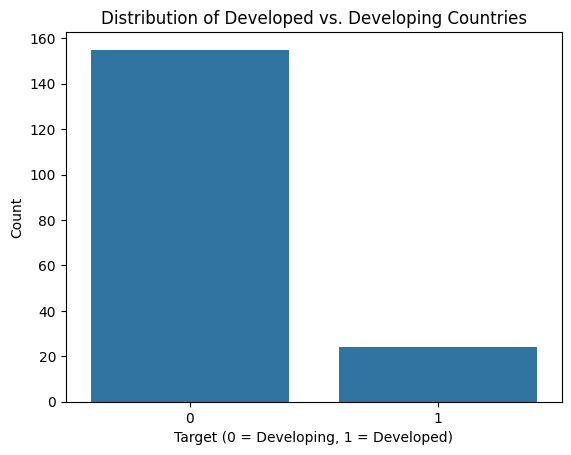

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

#Visualize the distribution of the target variable
sns.countplot(x=pandas_df['Target'])
plt.title('Distribution of Developed vs. Developing Countries')
plt.xlabel('Target (0 = Developing, 1 = Developed)')
plt.ylabel('Count')
plt.show()

In [54]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [55]:
X.shape

(179, 33)

In [56]:
y.shape

(179,)

In [57]:
#Train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
#Make predictions
y_pred = clf.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [59]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 84.44%
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.25      0.20      0.22         5

    accuracy                           0.84        45
   macro avg       0.58      0.56      0.57        45
weighted avg       0.83      0.84      0.84        45



In [60]:
#Function to make predictions based on user input
def predict_country_status(model, input_data):
    """
    Function to predict whether a country is developed or developing based on user input.

    Args:
    - model: Trained decision tree model.
    - input_data: List of user-provided values matching the order of training features.

    Returns:
    - str: 'Developed' or 'Developing' based on the model's prediction.
    """
    # Convert input list to a DataFrame
    input_df = pd.DataFrame([input_data], columns=X_train.columns)

    # Make prediction
    prediction = model.predict(input_df)

    return 'Developed' if prediction[0] == 1 else 'Developing'

# Example: Ask for user input
input_data = {
    'Density\n(P/Km2)': 500,
    'Agricultural Land(%)': 40,
    'Land Area(Km2)': 100000,
    'Armed Forces size': 100000,
    'Birth Rate': 10,
    'Calling Code': '+1',
    'Co2-Emissions': 5,
    'CPI': 2.5,
    'CPI Change (%)': 1.0,
    'Fertility Rate': 1.5,
    'Forested Area (%)': 30,
    'Gasoline Price': 3.5,
    'Gross primary education enrollment (%)': 98,
    'Gross tertiary education enrollment (%)': 60,
    'Infant mortality': 5,
    'Life expectancy': 80,
    'Maternal mortality ratio': 10,
    'Minimum wage': '1000',  # Assume this was categorical and encoded
    'Out of pocket health expenditure': 20,
    'Physicians per thousand': 3,
    'Population': 5000,
    'Population: Labor force participation (%)': 60,
    'Tax revenue (%)': 20,
    'Total tax rate': 30,
    'Unemployment rate': 5,
    'Urban_population': 80
}

# Call the function to make the prediction
prediction = predict_country_status(clf, input_data)
print(f"The predicted status of the country is: {prediction}")


The predicted status of the country is: Developing


In [61]:
input_data1 = {
    'Density\n(P/Km2)': 500,                 # Slightly higher density
    'Agricultural Land(%)': 43.099998,              # Lower agricultural land
    'Land Area(Km2)': 50,                # Slightly lower land area
    'Armed Forces size': 80,             # Reduced military size
    'Birth Rate': 11.78,                        # Low birth rate
    'Co2-Emissions': 56,                     # Adjusted emissions
    'CPI': 36,                              # Slightly higher inflation
    'Fertility Rate': 1.6200000047683716,                   # Low fertility rate
    'Life expectancy': 83,                   # Slightly higher life expectancy
    'Unemployment rate': 11.12	,                  # Reduced unemployment
    'Urban_population': 9797273.0                   # Increased urban population
}
prediction = predict_country_status(clf, input_data1)
print(f"The predicted status of the country is: {prediction}")

The predicted status of the country is: Developed


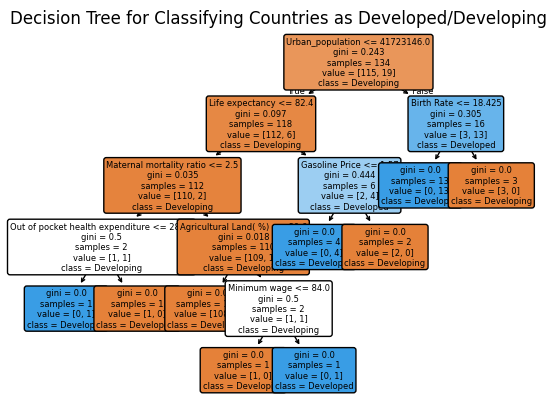

In [62]:
from sklearn import tree
import matplotlib.pyplot as plt

#Visualize the Decision Tree

# Plot the decision tree using the plot_tree function
tree.plot_tree(clf,
               feature_names=X.columns, # Use feature names for better readability
               class_names=['Developing', 'Developed'], # Label for target classes
               filled=True, # Fill the tree nodes with colors based on class
               rounded=True, # Rounded corners for nodes
               fontsize=6) # Control the font size for readability

plt.title("Decision Tree for Classifying Countries as Developed/Developing")
plt.show()


**Why we selected Decision tree and not other approach**

Decision trees can handle both numerical (e.g., GDP per capita, infant mortality rate) and categorical data (e.g., education levels), making them versatile for this type of data

Decision trees are well-suited for problems where relationships between features and outcomes are non-linear, meaning the model can capture complex patterns in the data that linear models might miss.

The goal is to classify countries into one of two classes: developed or developing, which fits perfectly into the binary classification that decision trees handle well.

Logistic Regression: Works well if the relationship between the predictors and the target is linear, but it may struggle with complex relationships.
